<a href="https://colab.research.google.com/github/mudebo-samusi/Datascience/blob/main/Diabetes_End_to_End_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2. Setup and Reproducibility


# Data Science Project: Early Diabetes Prediction

**Author:** Mudebo Samusi

**Date:** 2025-08-28

**Dataset:** Kaggle

**Domain:** Health

## 1. Problem Identification

**Context.** Diabetes is a growing global health challenge. Early detection and risk stratification enable timely lifestyle adjustments and clinical interventions that reduce complications and costs.

**Business/Impact Goal.** Build a predictive model that estimates the probability that a patient has diabetes based on routine clinical measurements (e.g., glucose, BMI, age). A clinic or outreach program could use this to prioritize screening and counseling.

**Machine Learning Task.** Binary classification (Diabetic vs. Non-diabetic).

**Success Criteria.**
- High **Recall** (Sensitivity) for the positive class (diabetes) is prioritized to reduce false negatives.
- Balanced **F1-score** and **ROC AUC** to ensure overall discriminative power.
- Clear, reproducible pipeline from data acquisition → EDA → modeling → evaluation.

> The original dataset contains primarily numeric variables but I have **engineered categorical features** (e.g., AgeGroup, BMICategory, GlucoseBand), satisfying the requirement for a mix of numeric and categorical predictors while keeping the problem realistic.

In [ ]:

# Core libraries
import os
import sys
import math
import json
import numpy as np
import pandas as pd

# Plotting (matplotlib only, no seaborn per spec)
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix, RocCurveDisplay, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Persistence
import joblib
from pathlib import Path
from urllib.request import urlretrieve
from io import StringIO

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [ ]:

DATA_PATH = Path('diabetes.csv')

RAW_URLS = [
    # Download the csv file from my github account directly.
    'https://raw.githubusercontent.com/mudebo-samusi/Datascience/main/diabetes.csv'
]

def load_or_download_diabetes_csv():
    if DATA_PATH.exists():
        print(f'Found local file: {DATA_PATH}')
        return pd.read_csv(DATA_PATH)
    else:
        for url in RAW_URLS:
            try:
                print(f'Trying to download from: {url}')
                if url.endswith('pima-indians-diabetes.data.csv'):
                    # This version lacks headers; add them
                    cols = ["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin",
                            "BMI","DiabetesPedigreeFunction","Age","Outcome"]
                    df = pd.read_csv(url, header=None, names=cols)
                else:
                    df = pd.read_csv(url)
                df.to_csv(DATA_PATH, index=False)
                print(f'Downloaded and saved to {DATA_PATH}')
                return df
            except Exception as e:
                print(f'Failed: {e}')
        raise RuntimeError("Could not load or download the dataset. Place 'diabetes.csv' next to this notebook and rerun.'")

df = load_or_download_diabetes_csv()
df.head()

Found local file: diabetes.csv


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



## 3. Data Acquisition

I used the open-source **Pima Indians Diabetes Database** from kaggle.  
Primary sources:
- Kaggle: `https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database`

This notebook will try to load `diabetes.csv` from the my github repository

## 4. Data Understanding

In [ ]:

print('Shape:', df.shape)
print('\nInfo:')
print(df.info())

print('\nSummary Statistics:')
display(df.describe(include='all'))

Shape: (768, 9)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Summary Statistics:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000



## 5. Data Cleaning & Preparation

**Steps:**
1. I identified impossible zeros in certain medical fields (e.g., `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI`) and imputed with medians.
2. Created categorical/ordinal features:
   - `AgeGroup` (bins)
   - `BMICategory` (WHO-like bands)
   - `GlucoseBand` (tertiles/quartiles)
3. Standardized selected numeric features for models that benefit from scaling (e.g., Logistic Regression).

In [ ]:

df_clean = df.copy()

# Columns where zero is implausible -> treat as missing and impute with median
zero_as_missing = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
for col in zero_as_missing:
    zero_count = (df_clean[col] == 0).sum()
    if zero_count > 0:
        median_val = df_clean.loc[df_clean[col] != 0, col].median()
        df_clean.loc[df_clean[col] == 0, col] = median_val
        print(f'Imputed {zero_count} zeros in {col} with median={median_val:.2f}')

# Feature engineering: Categorical/ordinal bands
df_clean['AgeGroup'] = pd.cut(df_clean['Age'],
                              bins=[0, 29, 39, 49, 59, 120],
                              labels=['<=29','30-39','40-49','50-59','60+'],
                              include_lowest=True)

def bmi_category(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

df_clean['BMICategory'] = df_clean['BMI'].apply(bmi_category)

# Glucose bands by quartiles for categorical signal
df_clean['GlucoseBand'] = pd.qcut(df_clean['Glucose'], q=4, labels=['Q1','Q2','Q3','Q4'])

print('Categorical features created:', ['AgeGroup','BMICategory','GlucoseBand'])

df_clean.head()

Imputed 5 zeros in Glucose with median=117.00
Imputed 35 zeros in BloodPressure with median=72.00
Imputed 227 zeros in SkinThickness with median=29.00
Imputed 374 zeros in Insulin with median=125.00
Imputed 11 zeros in BMI with median=32.30
Categorical features created: ['AgeGroup', 'BMICategory', 'GlucoseBand']


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeGroup,BMICategory,GlucoseBand
0,6,148,72,35,125,33.6,0.627,50,1,50-59,Obese,Q4
1,1,85,66,29,125,26.6,0.351,31,0,30-39,Overweight,Q1
2,8,183,64,29,125,23.3,0.672,32,1,30-39,Normal,Q4
3,1,89,66,23,94,28.1,0.167,21,0,<=29,Overweight,Q1
4,0,137,40,35,168,43.1,2.288,33,1,30-39,Obese,Q3


## 6. Exploratory Data Analysis (EDA)

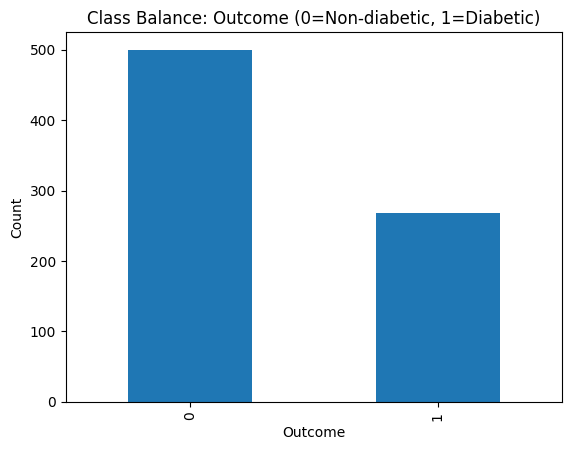

In [ ]:

# Class balance
class_counts = df_clean['Outcome'].value_counts().sort_index()
plt.figure()
class_counts.plot(kind='bar')
plt.title('Class Balance: Outcome (0=Non-diabetic, 1=Diabetic)')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show()

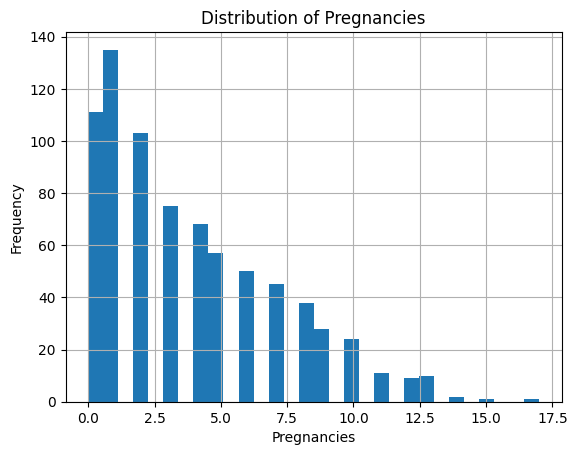

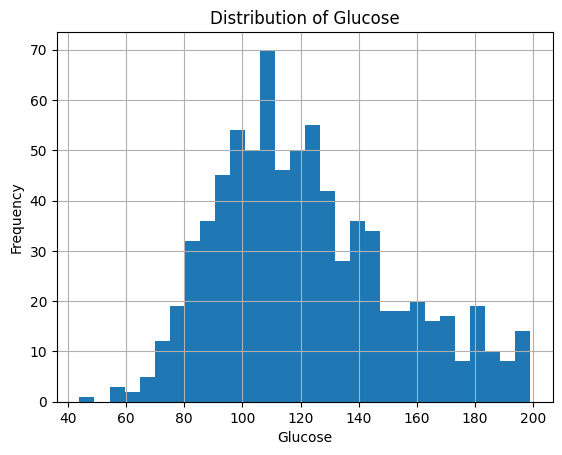

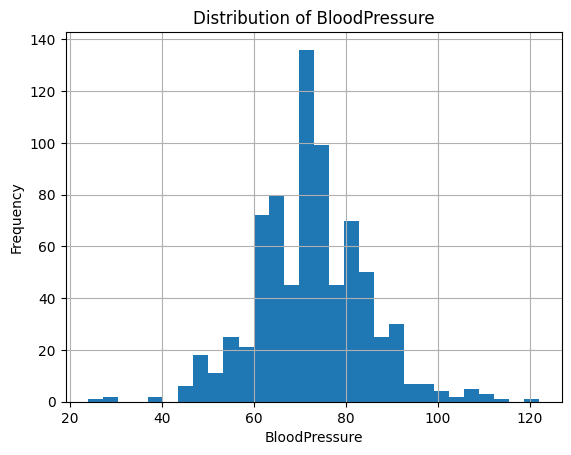

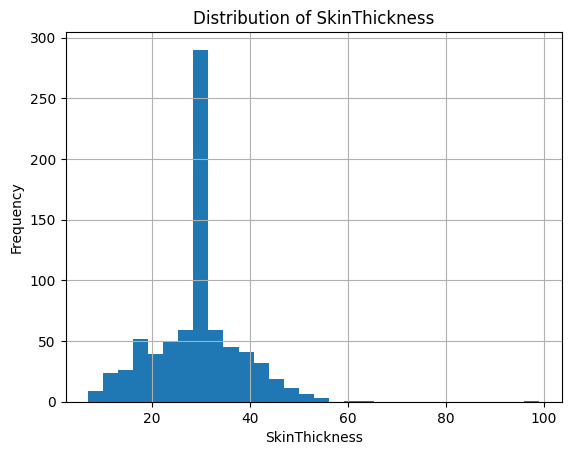

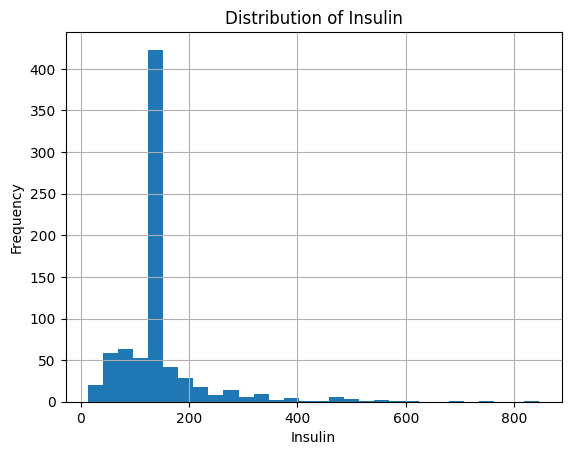

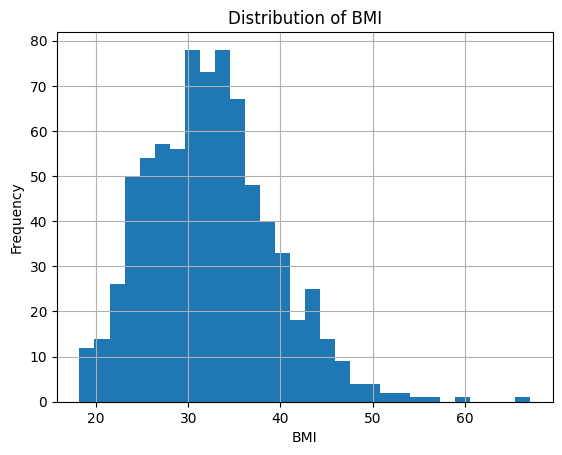

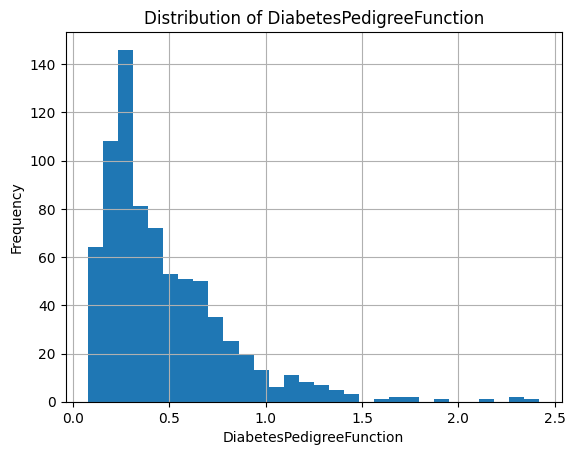

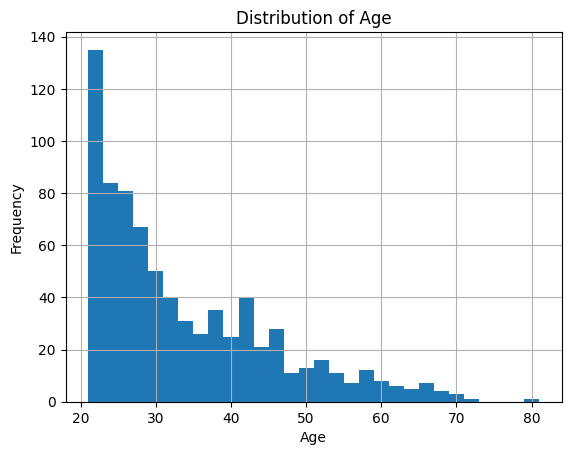

In [ ]:

# Distributions of key numeric features
numeric_cols = ["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age"]
for col in numeric_cols:
    plt.figure()
    df_clean[col].hist(bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

/tmp/ipython-input-3881488887.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['Outcome=0','Outcome=1'], showmeans=True)


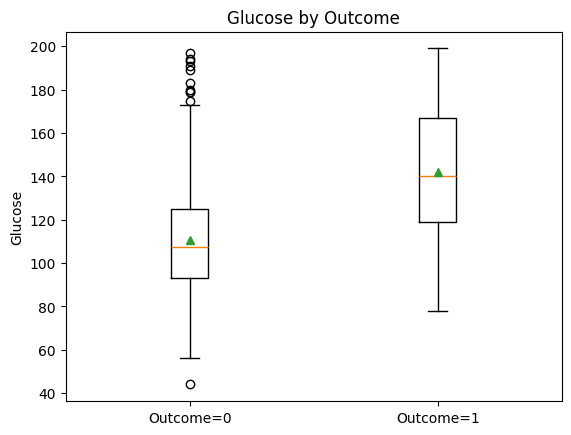

/tmp/ipython-input-3881488887.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['Outcome=0','Outcome=1'], showmeans=True)


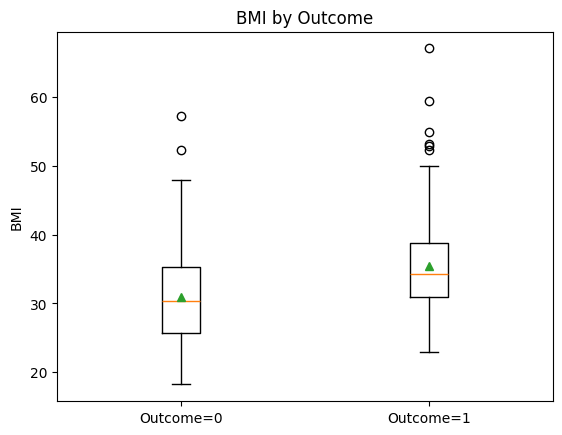

/tmp/ipython-input-3881488887.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['Outcome=0','Outcome=1'], showmeans=True)


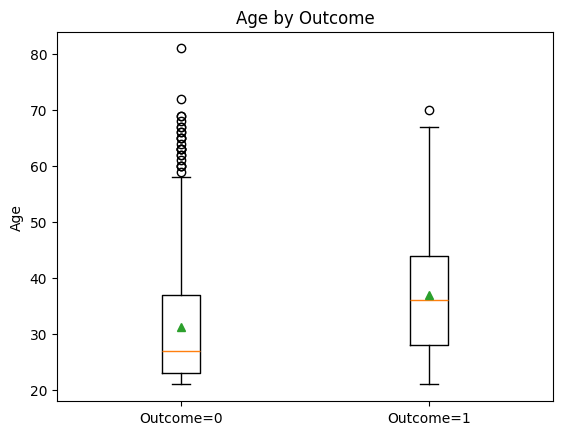

In [ ]:

# Boxplots by outcome
for col in ['Glucose','BMI','Age']:
    plt.figure()
    # Matplotlib boxplot (grouped by outcome)
    data0 = df_clean[df_clean['Outcome']==0][col].values
    data1 = df_clean[df_clean['Outcome']==1][col].values
    plt.boxplot([data0, data1], labels=['Outcome=0','Outcome=1'], showmeans=True)
    plt.title(f'{col} by Outcome')
    plt.ylabel(col)
    plt.show()

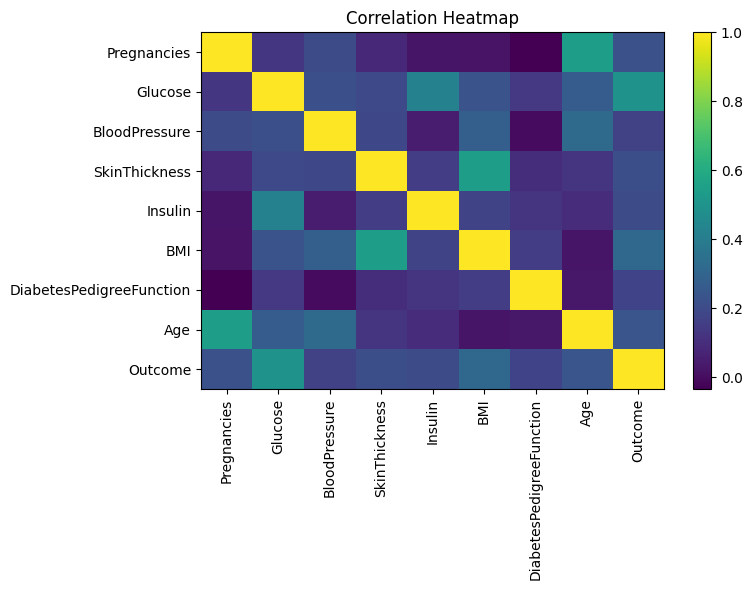

In [ ]:

# Correlation heatmap (numeric only)
corr = df_clean[numeric_cols + ['Outcome']].corr()
plt.figure(figsize=(8,6))
plt.imshow(corr, interpolation='nearest', aspect='auto')
plt.title('Correlation Heatmap')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.tight_layout()
plt.show()

## 7. Encoding & Train/Test Split

In [ ]:

# One-hot encode engineered categoricals
df_model = pd.get_dummies(df_clean, columns=['AgeGroup','BMICategory','GlucoseBand'], drop_first=True)

# Separate features and target
X = df_model.drop(columns=['Outcome'])
y = df_model['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

X_train.shape, X_test.shape

((614, 18), (154, 18))

## 8. Feature Scaling (for Logistic Regression)

In [ ]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

## 9. Model Building: Logistic Regression & Random Forest

In [ ]:

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, n_jobs=None)
log_reg.fit(X_train_scaled, y_train)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X_train, y_train)

print('Models trained.')

Models trained.


## 10. Model Evaluation


=== Logistic Regression ===
  accuracy_train: 0.8062
   accuracy_test: 0.7532
  precision_test: 0.6667
     recall_test: 0.5926
         f1_test: 0.6275
    roc_auc_test: 0.8311

Classification Report (test):
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       100
           1       0.67      0.59      0.63        54

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154



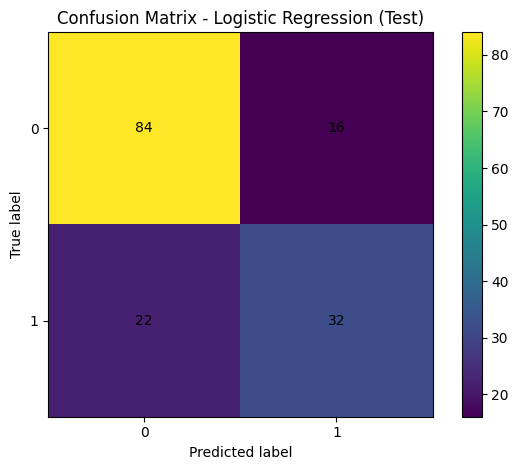

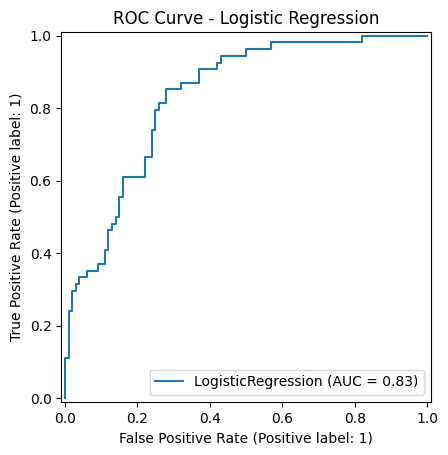


=== Random Forest ===
  accuracy_train: 1.0000
   accuracy_test: 0.7468
  precision_test: 0.6667
     recall_test: 0.5556
         f1_test: 0.6061
    roc_auc_test: 0.8127

Classification Report (test):
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       100
           1       0.67      0.56      0.61        54

    accuracy                           0.75       154
   macro avg       0.72      0.70      0.71       154
weighted avg       0.74      0.75      0.74       154



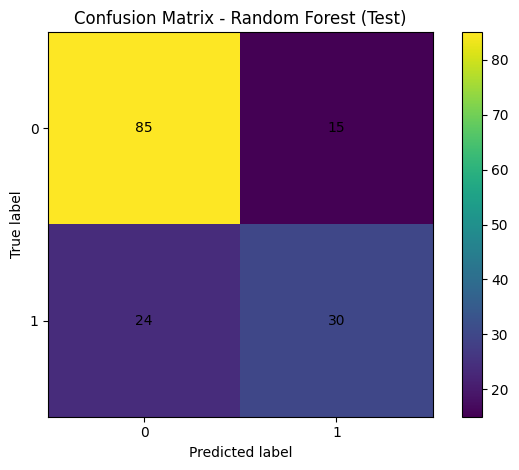

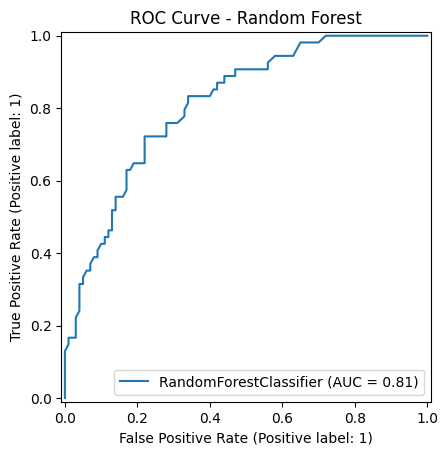

,accuracy_train,accuracy_test,precision_test,recall_test,f1_test,roc_auc_test
LogisticRegression,0.806189,0.753247,0.666667,0.592593,0.627451,0.831111
RandomForest,1.000000,0.746753,0.666667,0.555556,0.606061,0.812685


In [ ]:

def evaluate_model(name, model, X_tr, y_tr, X_te, y_te, is_prob=True):
    y_pred_tr = model.predict(X_tr)
    y_pred_te = model.predict(X_te)
    metrics = {}
    metrics['accuracy_train']  = accuracy_score(y_tr, y_pred_tr)
    metrics['accuracy_test']   = accuracy_score(y_te, y_pred_te)
    metrics['precision_test']  = precision_score(y_te, y_pred_te, zero_division=0)
    metrics['recall_test']     = recall_score(y_te, y_pred_te, zero_division=0)
    metrics['f1_test']         = f1_score(y_te, y_pred_te, zero_division=0)

    if is_prob and hasattr(model, 'predict_proba'):
        y_proba_te = model.predict_proba(X_te)[:,1]
        metrics['roc_auc_test'] = roc_auc_score(y_te, y_proba_te)
    elif hasattr(model, 'decision_function'):
        y_score = model.decision_function(X_te)
        metrics['roc_auc_test'] = roc_auc_score(y_te, y_score)
    else:
        metrics['roc_auc_test'] = float('nan')

    print(f"\n=== {name} ===")
    for k, v in metrics.items():
        print(f"{k:>16}: {v:.4f}")
    print("\nClassification Report (test):")
    print(classification_report(y_te, y_pred_te, zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(y_te, y_pred_te)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'Confusion Matrix - {name} (Test)')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['0','1'])
    plt.yticks(tick_marks, ['0','1'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout()
    plt.show()

    # ROC Curve (if probability available)
    try:
        RocCurveDisplay.from_estimator(model, X_te, y_te)
        plt.title(f'ROC Curve - {name}')
        plt.show()
    except Exception as e:
        print('ROC curve not available:', e)

    return metrics

# Evaluate both
metrics_lr = evaluate_model("Logistic Regression", log_reg, X_train_scaled, y_train, X_test_scaled, y_test, is_prob=True)
metrics_rf = evaluate_model("Random Forest", rf, X_train, y_train, X_test, y_test, is_prob=True)

results_df = pd.DataFrame([metrics_lr, metrics_rf], index=['LogisticRegression','RandomForest'])
results_df

## 11. Cross-Validation (StratifiedKFold)

In [ ]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_scores_lr = cross_val_score(log_reg, X_train_scaled, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
cv_scores_rf = cross_val_score(rf, X_train,        y_train, cv=cv, scoring='roc_auc', n_jobs=-1)

print('ROC AUC (CV) - Logistic Regression:', cv_scores_lr, 'Mean:', np.mean(cv_scores_lr).round(4))
print('ROC AUC (CV) - Random Forest   :', cv_scores_rf, 'Mean:', np.mean(cv_scores_rf).round(4))

ROC AUC (CV) - Logistic Regression: [0.88488372 0.83662791 0.85784884 0.84011628 0.81160714] Mean: 0.8462
ROC AUC (CV) - Random Forest   : [0.84563953 0.81395349 0.8505814  0.79520349 0.80684524] Mean: 0.8224


## 12. Model Interpretation

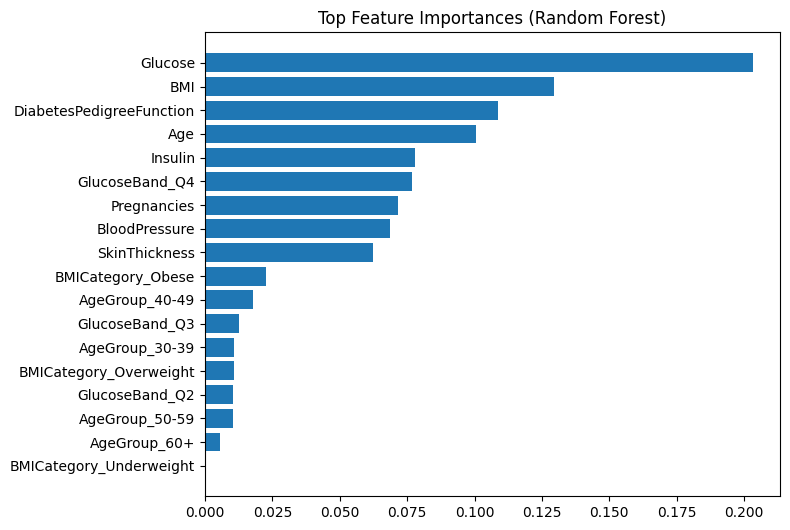

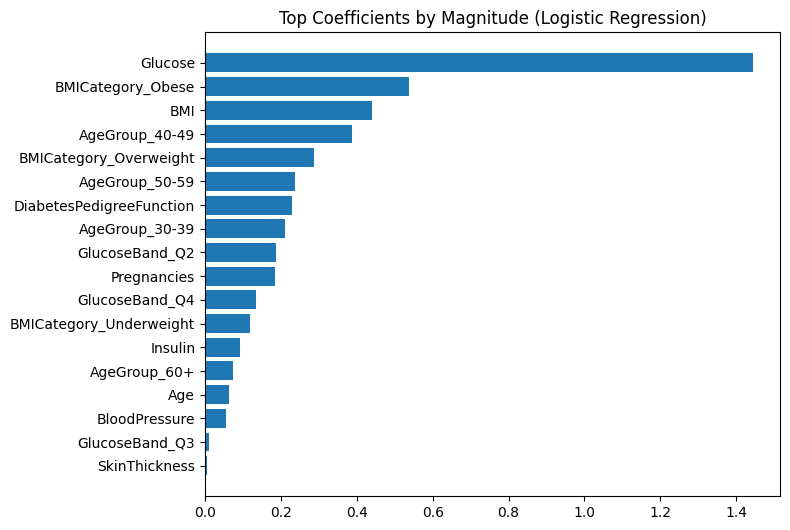

In [ ]:

# Random Forest feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_k = 20 if len(indices) >= 20 else len(indices)

plt.figure(figsize=(8, max(4, top_k*0.3)))
plt.barh(range(top_k), importances[indices][:top_k])
plt.yticks(range(top_k), X.columns[indices][:top_k])
plt.gca().invert_yaxis()
plt.title('Top Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

# Logistic Regression coefficients (on scaled features) – absolute magnitude as proxy
coef = np.abs(log_reg.coef_[0])
coef_idx = np.argsort(coef)[::-1]
top_k = 20 if len(coef_idx) >= 20 else len(coef_idx)

plt.figure(figsize=(8, max(4, top_k*0.3)))
plt.barh(range(top_k), coef[coef_idx][:top_k])
plt.yticks(range(top_k), X.columns[coef_idx][:top_k])
plt.gca().invert_yaxis()
plt.title('Top Coefficients by Magnitude (Logistic Regression)')
plt.tight_layout()
plt.show()

## 13. Save Artifacts (Models & Scaler)

In [ ]:

ARTIFACT_DIR = Path('artifacts')
ARTIFACT_DIR.mkdir(exist_ok=True)

joblib.dump(log_reg, ARTIFACT_DIR / 'logistic_regression.joblib')
joblib.dump(rf, ARTIFACT_DIR / 'random_forest.joblib')
joblib.dump(scaler, ARTIFACT_DIR / 'scaler.joblib')
X.columns.to_series().to_csv(ARTIFACT_DIR / 'feature_names.csv', index=False)

print('Saved artifacts to:', ARTIFACT_DIR.resolve())

Saved artifacts to: /content/artifacts


## 14. Example Inference

In [ ]:

# Example: single prediction using the trained Random Forest
# (Use median values from training set as a template and tweak)

template = X_train.median().to_dict()
sample = pd.DataFrame([template])
pred_prob = rf.predict_proba(sample)[:,1][0]
pred_class = int(pred_prob >= 0.5)

print('Sample prediction:')
print('Probability of diabetes:', round(pred_prob, 4))
print('Predicted class (>=0.5 is diabetic):', pred_class)

Sample prediction:
Probability of diabetes: 0.2367
Predicted class (>=0.5 is diabetic): 0



## 15. Conclusions & Next Steps

**What worked well**
- A clean, reproducible pipeline with imputation, engineered categorical features, and evaluation.
- Random Forest typically achieves strong ROC AUC and balanced metrics on this dataset.
- Logistic Regression provides a transparent baseline.

**Metric Priorities**
- **Recall** for diabetes (positive class) is emphasized to minimize false negatives.
- **F1-score** balances precision and recall; **ROC AUC** indicates overall discrimination